### EfficientNet-Based Convolutional Neural Networks for Multi-class Image Classification

#### Introduction: 
This project explores the use of Convolutional Neural Networks (CNNs), focusing on EfficientNet-based models, to distinguish between buildings and forests. This classification is usefull for managing water resources in arid areas, such as Saudi Arabia, where identifying vegetation and water sources is vital for sustainable development and environmental conservation. The approach involves fine-tuning pre-trained CNNs, offering a practical solution to the challenges of limited data, computational resources, and time constraints.

**Step 1: Import necessary libraries.**

In [1]:
!pip install torch torchvision timm

In [2]:
!pip install --upgrade timm

In [3]:
import torch  # Importing PyTorch for deep learning
import torchvision  # PyTorch package for working with image data
import torchvision.transforms as transforms  # For image transformations
from torchvision.datasets import ImageFolder  # Dataset class for image folders
import timm  # Importing 'timm' for accessing pre-built models like EfficientNet
import torch.utils.data  # Utilities for data loading
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
from PIL import Image  # Python Imaging Library for image manipulation
from IPython.display import display, Image as IPImage  # Display utilities for Jupyter notebooks
import os  # Interface with the operating system
from collections import Counter  # For counting objects
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting library
from sklearn.metrics import confusion_matrix
import seaborn as sns

**Step2: Load the dataset and Preprocess the Data.**

In [4]:
#preprocessing pipeline and class definitions
# Data transformations
transform = transforms.Compose(
    [transforms.Resize((224, 224)),  # Resize images to 224x224
     transforms.ToTensor(),  # Convert images to Tensor
     transforms.RandomHorizontalFlip(), # Randomly flips images horizontally
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # Normalize the images
)
# The 10 classes in the dataset
class_names = ['building', 'forest']

**Step3: Create Training and Testing Dataset.**

In [5]:
train_path = 'C:\\Users\\96655\\Downloads\\buildings-vs-forests\\traning_set'
test_path = 'C:\\Users\\96655\\Downloads\\buildings-vs-forests\\test_set'

# Load your dataset
train_dataset = ImageFolder(root=train_path, transform=transform)
test_dataset = ImageFolder(root=test_path, transform=transform)

# DataLoader to batch and shuffle the data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)  
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

**Step4: Explore and analyze the Data.**

***First: Training dataset***

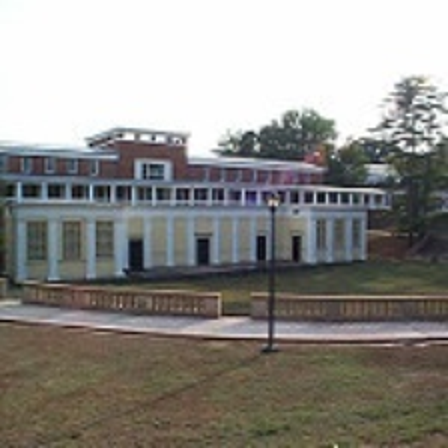

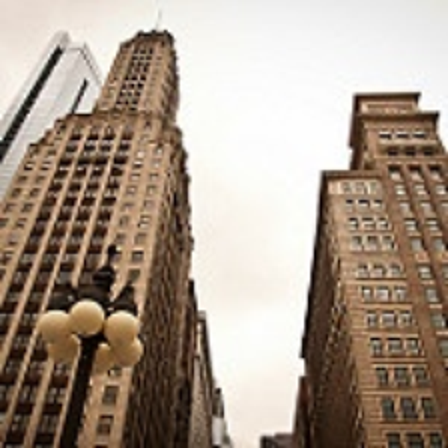

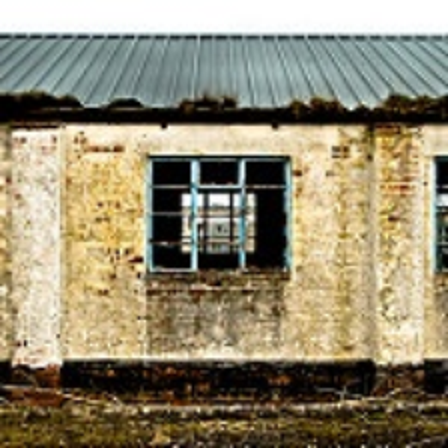

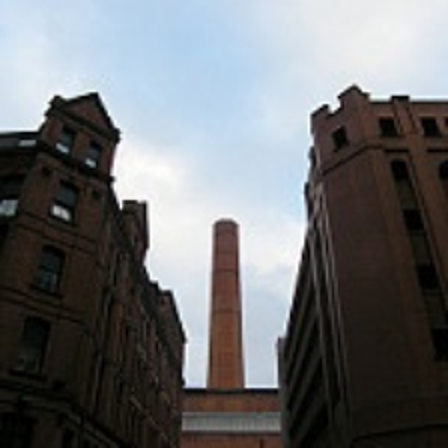

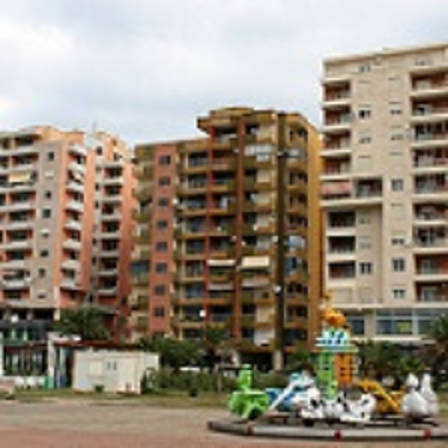

In [6]:
# Visualizing Sample Images

# Get a batch of data from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Loop through the images and save and display them
for i in range(5):
    image = images[i].permute(1, 2, 0)  # Transpose the image tensor for visualization
    image = (image * 0.5 + 0.5) * 255  # Convert image tensor to [0, 255] range
    image = image.byte()  # Convert image tensor to byte format (0-255)
    
    # Create a PIL image from the byte tensor
    pil_image = Image.fromarray(image.numpy())
    
    # Increase image size (doubling the size here)
    new_size = (pil_image.size[0] * 2, pil_image.size[1] * 2)
    pil_image_resized = pil_image.resize(new_size)
    
    # Save the image to a file
    image_filename = f"image_{i}.png"
    pil_image_resized.save(image_filename)
    
    # Display the saved image using IPython.display
    display(IPImage(filename=image_filename))   
    
    # Delete the saved image file to avoid cluttering the directory
    os.remove(image_filename)


In [7]:
# Average Color Intensity Analysis

avg_intensity = [image.float().mean() for image, _ in train_dataset]
print("Average color intensity in the dataset:", np.mean(avg_intensity))

Average color intensity in the dataset: -0.23510712


In [8]:
# Assessing Unique Image Shapes

image_shapes = [image.shape for image, _ in train_dataset]
unique_shapes = set(image_shapes)
print("Unique image shapes in the dataset:", unique_shapes)

Unique image shapes in the dataset: {torch.Size([3, 224, 224])}


In [9]:
# The distribution of classes in the dataset

labels = [label for _, label in train_dataset]
label_count = Counter(labels)

# Mapping numerical labels to class names
label_count_named = {class_names[label]: count for label, count in label_count.items()}

print("Distribution of classes in the dataset:", label_count_named)

Distribution of classes in the dataset: {'building': 2190, 'forest': 2253}


***Second: Testing dataset***

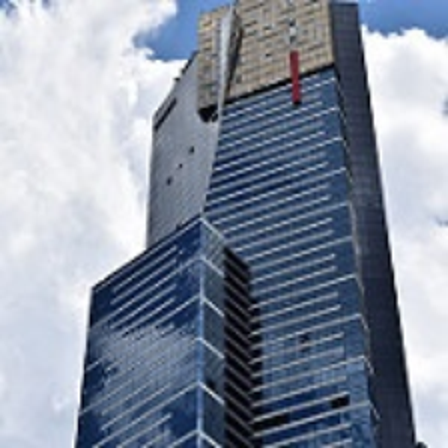

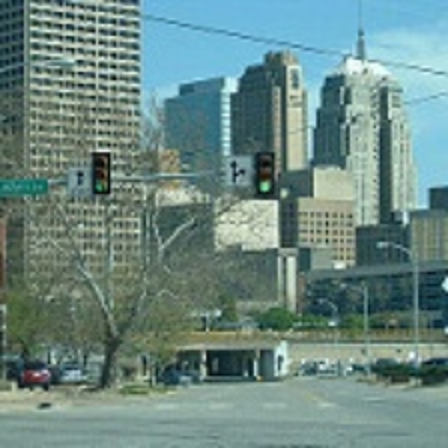

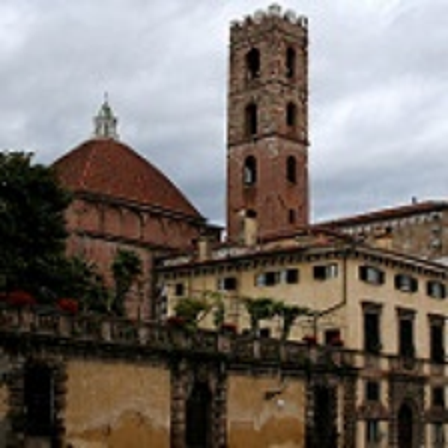

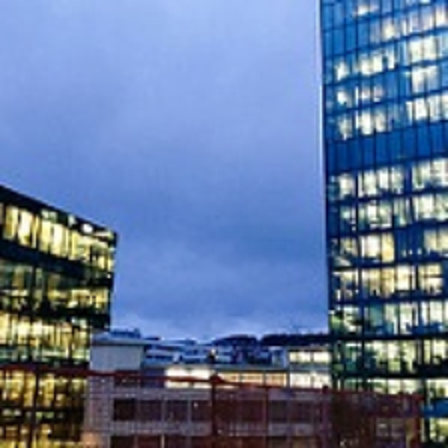

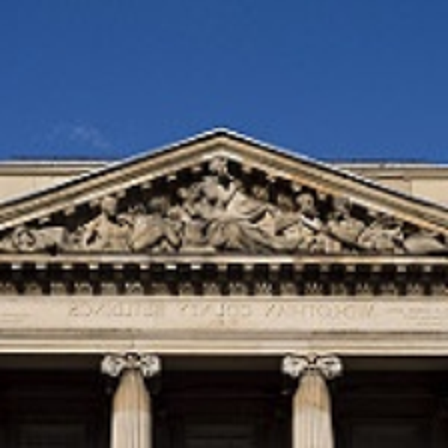

In [10]:
# Visualizing Sample Images:

# Get a batch of data from the train_loader
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Loop through the images and save and display them
for i in range(5):
    image = images[i].permute(1, 2, 0)  # Transpose the image tensor for visualization
    image = (image * 0.5 + 0.5) * 255  # Convert image tensor to [0, 255] range
    image = image.byte()  # Convert image tensor to byte format (0-255)
    
    # Create a PIL image from the byte tensor
    pil_image = Image.fromarray(image.numpy())
    
    # Increase image size (doubling the size here)
    new_size = (pil_image.size[0] * 2, pil_image.size[1] * 2)
    pil_image_resized = pil_image.resize(new_size)
    
    # Save the image to a file
    image_filename = f"image_{i}.png"
    pil_image_resized.save(image_filename)
    
    # Display the saved image using IPython.display
    display(IPImage(filename=image_filename))   
    
    # Delete the saved image file to avoid cluttering the directory
    os.remove(image_filename)

In [11]:
# Average Color Intensity Analysis

avg_intensity = [image.float().mean() for image, _ in test_dataset]
print("Average color intensity in the dataset:", np.mean(avg_intensity))

Average color intensity in the dataset: -0.23865978


In [12]:
# Assessing Unique Image Shapes

image_shapes = [image.shape for image, _ in test_dataset]
unique_shapes = set(image_shapes)
print("Unique image shapes in the dataset:", unique_shapes)

Unique image shapes in the dataset: {torch.Size([3, 224, 224])}


In [13]:
# The distribution of classes in the dataset

labels = [label for _, label in test_dataset]
label_count = Counter(labels)

# Mapping numerical labels to class names
label_count_named = {class_names[label]: count for label, count in label_count.items()}

print("Distribution of classes in the dataset:", label_count_named)

Distribution of classes in the dataset: {'building': 437, 'forest': 474}


**Step5: Modify and Fine-Tune the EfficientNet Model.**

In [14]:
# Check if CUDA (GPU support) is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the EfficientNet-B7 model 
model = timm.create_model('efficientnet_b0', pretrained=False)

# Modify the classifier to fit your specific dataset
# Assuming your dataset has 2 classes (buildings and forests)
num_features = model.classifier.in_features
model.classifier = torch.nn.Linear(num_features, 2)

# Move the model to the GPU if available
model.to(device)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

**Step6: Train and Evaluate the Model.**

In [15]:
# Experiment 1
criterion = nn.CrossEntropyLoss()
optimizer_exp1 = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler_exp1 = optim.lr_scheduler.StepLR(optimizer_exp1, step_size=30, gamma=0.1)
optimizer = optimizer_exp1
scheduler = scheduler_exp1

In [16]:
for epoch in range(6):
    model.train()  # Set the model to training mode
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradient buffers
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
 
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Clear some memory
    if device == 'cuda':
        torch.cuda.empty_cache()

Epoch 1, Loss: 0.3552153408527374
Epoch 2, Loss: 0.20661242306232452
Epoch 3, Loss: 0.012004230171442032
Epoch 4, Loss: 0.0002512459468562156
Epoch 5, Loss: 1.628548264503479
Epoch 6, Loss: 3.6188347339630127


In [17]:
# Lists to store predictions and true labels
all_predictions = []
all_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = sum(p == t for p, t in zip(all_predictions, all_labels))
total = len(all_labels)
accuracy = 100 * correct / total
print(f'Accuracy of the model on the train images: {accuracy}%')

Accuracy of the model on the train images: 98.98717083051991%


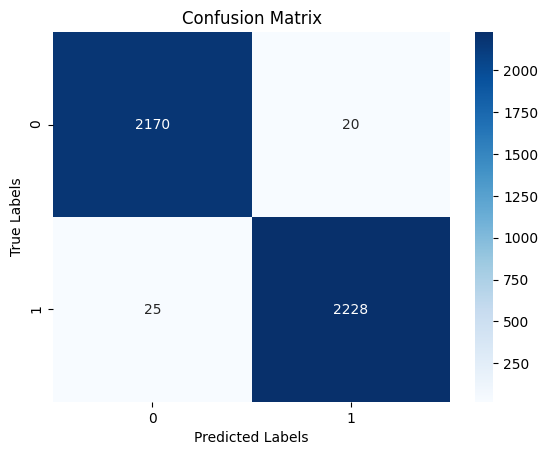

In [18]:
# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Set the model to evaluation mode
model.eval()

# Track the number of correct predictions and total predictions
correct = 0
total = 0

# Disable gradient calculation as it's not needed for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')

Accuracy of the model on the test images: 98.13391877058177%


In [20]:
# Experiment 2
criterion = nn.CrossEntropyLoss()
optimizer_exp2 = optim.SGD(model.parameters(), lr=0.01, momentum=0.7, weight_decay=0.0005)
scheduler_exp2 = optim.lr_scheduler.StepLR(optimizer_exp2, step_size=30, gamma=0.1)

optimizer = optimizer_exp2
scheduler = scheduler_exp2

In [21]:
for epoch in range(6):
    model.train()  
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradient buffers
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
 
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Clear some memory
    if device == 'cuda':
        torch.cuda.empty_cache()

Epoch 1, Loss: 0.000848998490255326
Epoch 2, Loss: 0.0002228997618658468
Epoch 3, Loss: 0.008179623633623123
Epoch 4, Loss: 0.00014537321112584323
Epoch 5, Loss: 0.0007742866291664541
Epoch 6, Loss: 0.00019255270308349282


In [22]:
# Lists to store predictions and true labels
all_predictions = []
all_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = sum(p == t for p, t in zip(all_predictions, all_labels))
total = len(all_labels)
accuracy = 100 * correct / total
print(f'Accuracy of the model on the train images: {accuracy}%')

Accuracy of the model on the train images: 99.88746342561332%


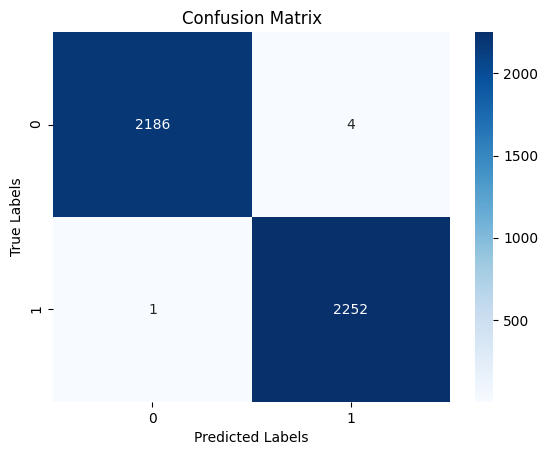

In [23]:
# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Set the model to evaluation mode
model.eval()

# Track the number of correct predictions and total predictions
correct = 0
total = 0

# Disable gradient calculation as it's not needed for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')

Accuracy of the model on the test images: 98.35345773874863%


In [25]:
# Experiment 3
criterion = nn.CrossEntropyLoss()
optimizer_exp3 = optim.Adam(model.parameters(), lr=0.1)
scheduler_exp3 = optim.lr_scheduler.StepLR(optimizer_exp3, step_size=30, gamma=0.4)

optimizer = optimizer_exp3
scheduler = scheduler_exp3

In [26]:
for epoch in range(6):
    model.train()  
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
 
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Clear some memory
    if device == 'cuda':
        torch.cuda.empty_cache()

Epoch 1, Loss: 0.974149227142334
Epoch 2, Loss: 4.825351715087891
Epoch 3, Loss: 1.252143144607544
Epoch 4, Loss: 0.006920385640114546
Epoch 5, Loss: 4.273593425750732
Epoch 6, Loss: 0.6982088088989258


In [27]:
# Lists to store predictions and true labels
all_predictions = []
all_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = sum(p == t for p, t in zip(all_predictions, all_labels))
total = len(all_labels)
accuracy = 100 * correct / total
print(f'Accuracy of the model on the train images: {accuracy}%')

Accuracy of the model on the train images: 57.528696826468604%


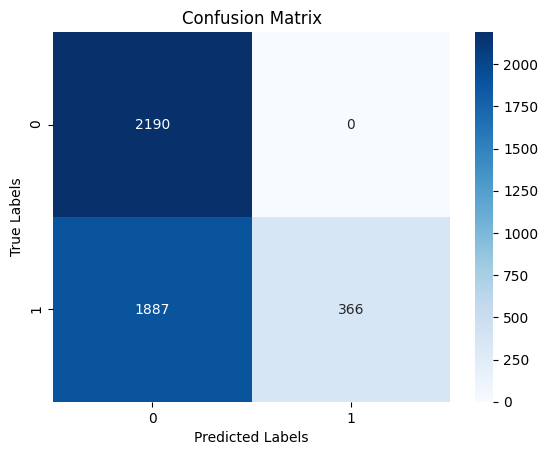

In [28]:
# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [29]:
# Set the model to evaluation mode
model.eval()

# Track the number of correct predictions and total predictions
correct = 0
total = 0

# Disable gradient calculation as it's not needed for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')

Accuracy of the model on the test images: 54.665203073545555%


In [30]:
# Experiment 4
criterion = nn.CrossEntropyLoss()
optimizer_exp4 = optim.AdamW(model.parameters(), lr=0.01)  # Adjust lr as needed
scheduler_exp4 = optim.lr_scheduler.StepLR(optimizer_exp3, step_size=70, gamma=0.1)

optimizer = optimizer_exp4
scheduler = scheduler_exp4

In [31]:
for epoch in range(6):
    model.train()  # Set the model to training mode
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradient buffers
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
 
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Clear some memory
    if device == 'cuda':
        torch.cuda.empty_cache()

Epoch 1, Loss: 0.08695045858621597
Epoch 2, Loss: 0.08036874234676361
Epoch 3, Loss: 2.821280531861703e-06
Epoch 4, Loss: 0.001807570457458496
Epoch 5, Loss: 0.0037342291325330734
Epoch 6, Loss: 0.0004112548194825649


In [32]:
# Lists to store predictions and true labels
all_predictions = []
all_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = sum(p == t for p, t in zip(all_predictions, all_labels))
total = len(all_labels)
accuracy = 100 * correct / total
print(f'Accuracy of the model on the train images: {accuracy}%')

Accuracy of the model on the train images: 97.61422462300247%


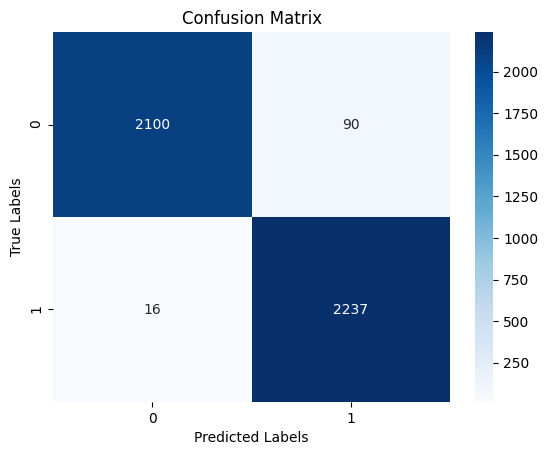

In [33]:
# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# Set the model to evaluation mode
model.eval()

# Track the number of correct predictions and total predictions
correct = 0
total = 0

# Disable gradient calculation as it's not needed for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')

Accuracy of the model on the test images: 98.02414928649836%


In [35]:
# Experiment 5
criterion = nn.CrossEntropyLoss()
optimizer_exp5 = optim.SGD(model.parameters(), lr=0.001, momentum=0.8, weight_decay=0.0005)
scheduler_exp5 = optim.lr_scheduler.StepLR(optimizer_exp5, step_size=30, gamma=0.1)
optimizer = optimizer_exp5
scheduler = scheduler_exp5

In [36]:
for epoch in range(6):
    model.train()  # Set the model to training mode
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradient buffers
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
 
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Clear some memory
    if device == 'cuda':
        torch.cuda.empty_cache()

Epoch 1, Loss: 0.0016729746712371707
Epoch 2, Loss: 0.0014440384693443775
Epoch 3, Loss: 0.008356129750609398
Epoch 4, Loss: 0.0013803631300106645
Epoch 5, Loss: 0.005704057868570089
Epoch 6, Loss: 0.0023725300561636686


In [37]:
# Lists to store predictions and true labels
all_predictions = []
all_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = sum(p == t for p, t in zip(all_predictions, all_labels))
total = len(all_labels)
accuracy = 100 * correct / total
print(f'Accuracy of the model on the train images: {accuracy}%')

Accuracy of the model on the train images: 98.35696601395453%


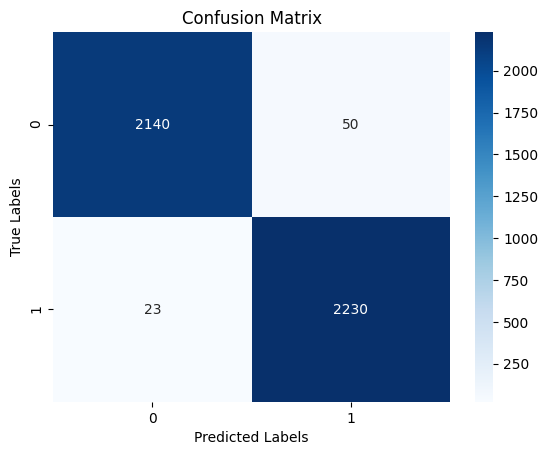

In [38]:
# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [39]:
# Set the model to evaluation mode
model.eval()

# Track the number of correct predictions and total predictions
correct = 0
total = 0

# Disable gradient calculation as it's not needed for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')

Accuracy of the model on the test images: 98.79253567508233%


**Step7: Predicting Unseen Images.**

***First: Building class images***

In [40]:
from IPython.display import display, Image
from PIL import Image
from IPython.display import Image as IPImage, display

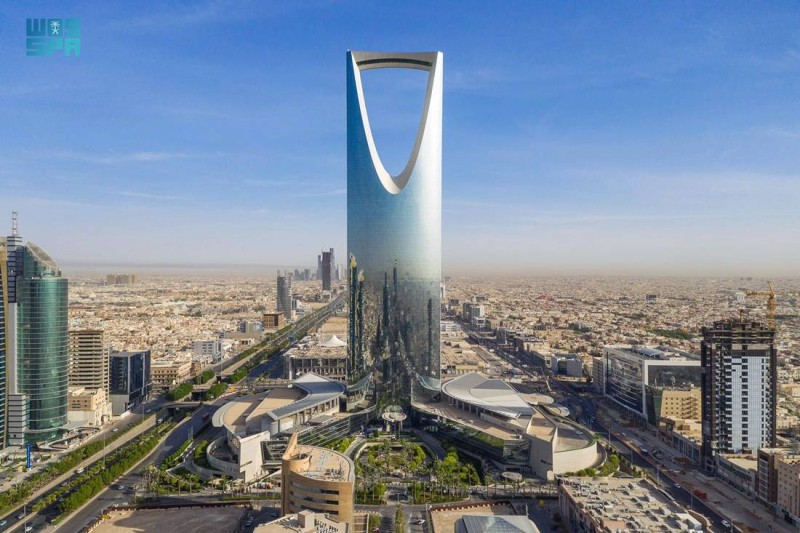

In [41]:
# Display the image using IPython.display
display(Image(filename='C:\\Users\\96655\\Downloads\\BUL.jpg'))

In [43]:
# Load the image
from PIL import Image

image_path1 = 'C:\\Users\\96655\\Downloads\\BUL.jpg'

image = Image.open(image_path1).convert('RGB')

# Preprocess the image
image = transform(image)

# Add an extra batch dimension since PyTorch treats all inputs as batches
image = image.unsqueeze(0)

# Set the model to evaluation mode and move to CPU
model.eval()
model.to('cpu')

# Move the image to CPU
image = image.to('cpu')

# Make the prediction
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

# predicted now contains the predicted class index
predicted_class_index = predicted.item()
# Print class name based on predicted class index
predicted_class_name = class_names[predicted_class_index]
print(f'Predicted class: {predicted_class_name}')

Predicted class: building


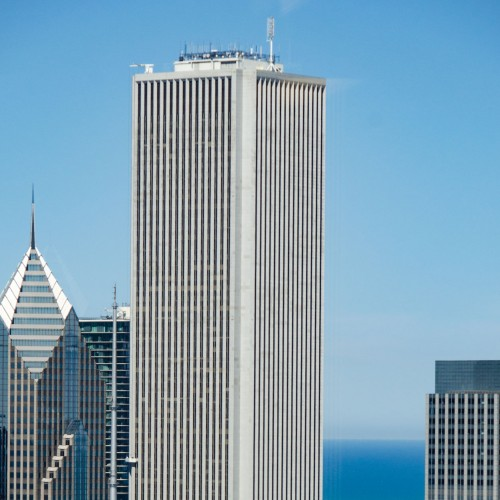

In [50]:
# Load the image using PIL
pil_image = Image.open('C:\\Users\\96655\\Downloads\\BUL2.jpg').convert('RGB')

# Display the image using IPython.display
display(IPImage(filename='C:\\Users\\96655\\Downloads\\BUL2.jpg'))

In [45]:
# Load the image
image_path1 = 'C:\\Users\\96655\\Downloads\\BUL2.jpg'

image = Image.open(image_path1).convert('RGB')

# Preprocess the image
image = transform(image)

# Add an extra batch dimension since PyTorch treats all inputs as batches
image = image.unsqueeze(0)

# Set the model to evaluation mode and move to CPU
model.eval()
model.to('cpu')

# Move the image to CPU
image = image.to('cpu')

# Make the prediction
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

# predicted now contains the predicted class index
predicted_class_index = predicted.item()
# Print class name based on predicted class index
predicted_class_name = class_names[predicted_class_index]
print(f'Predicted class: {predicted_class_name}')

Predicted class: building


***Second: Forest class images***

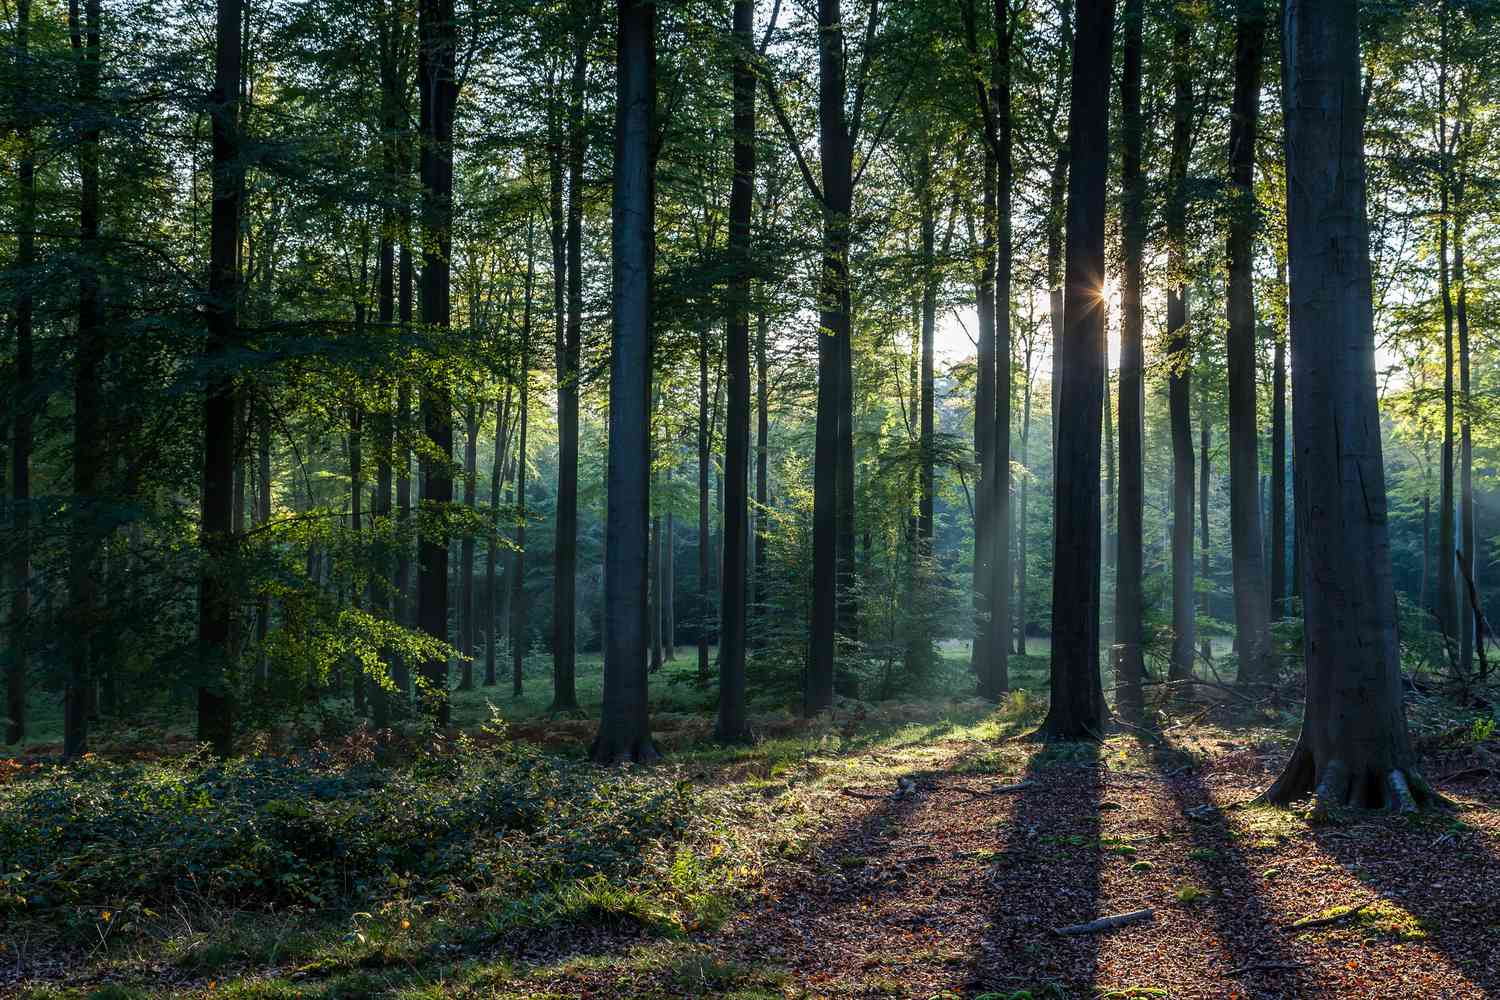

In [51]:
# Load the image using PIL
pil_image = Image.open('C:\\Users\\96655\\Downloads\\FOREST.jpg').convert('RGB')

# Display the image using IPython.display
display(IPImage(filename='C:\\Users\\96655\\Downloads\\FOREST.jpg'))

In [47]:
# Load the image
image_path = 'C:\\Users\\96655\\Downloads\\FOREST.jpg'
image = Image.open(image_path).convert('RGB')

# Preprocess the image
image = transform(image)

# Add an extra batch dimension since PyTorch treats all inputs as batches
image = image.unsqueeze(0)

# Set the model to evaluation mode and move to CPU
model.eval()
model.to('cpu')

# Move the image to CPU
image = image.to('cpu')

# Make the prediction
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

# predicted now contains the predicted class index
predicted_class_index = predicted.item()

# Print class name based on predicted class index
predicted_class_name = class_names[predicted_class_index]
print(f'Predicted class: {predicted_class_name}')

Predicted class: forest


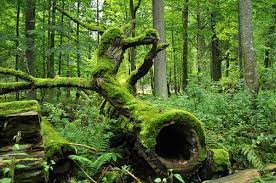

In [52]:
# Load the image using PIL
pil_image = Image.open('C:\\Users\\96655\\Downloads\\FOREST1.jpg').convert('RGB')

# Display the image using IPython.display
display(IPImage(filename='C:\\Users\\96655\\Downloads\\FOREST1.jpg'))

In [49]:
# Load the image
image_path = 'C:\\Users\\96655\\Downloads\\FOREST1.jpg'
image = Image.open(image_path).convert('RGB')

# Preprocess the image
image = transform(image)

# Add an extra batch dimension since PyTorch treats all inputs as batches
image = image.unsqueeze(0)

# Set the model to evaluation mode and move to CPU
model.eval()
model.to('cpu')

# Move the image to CPU
image = image.to('cpu')

# Make the prediction
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

# predicted now contains the predicted class index
predicted_class_index = predicted.item()
# Print class name based on predicted class index
class_names = ['building', 'forest']  # Define your class names
predicted_class_name = class_names[predicted_class_index]
print(f'Predicted class: {predicted_class_name}')

Predicted class: forest
